In [3]:
!pip install shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [37]:


import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='crest', font_scale=0.8)

import matplotlib
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import shap
shap.initjs()
import xgboost


### Task 1.1

In [6]:
df = pd.read_csv("risk_factors_cervical_cancer.csv")

df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


In [8]:
df.describe()

,Age,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Task 1.2

In [9]:
def encode_nans(df):
    """
    Convert the special characters to nans so we can use nan processing code, 
    available in pandas.
    """
    return df.replace('?', np.NaN)

def fill_nan_mode(df, columns):
    """Fills nans in specified columns with the mode of that column"""
    new_df = df.copy(deep=True)
    for col in df.columns:
      if col in columns:
        new_df[col] = df[col].fillna(df[col].mode()[0])
    return new_df

def fill_nan_mean(df, columns):
    """Fills nans in specified columns with the mode of that column"""
    new_df = df.copy(deep=True)
    for col in df.columns:
      if col in columns:
        new_df[col] = df[col].fillna(df[col].mean())
    return new_df

def drop_nulls(df, threshold):
    """Drop the the column with certain proportion NaN value."""
    cols = [x for x in df.columns if df[x].isnull().sum() / df.shape[0] > threshold]
    return df.drop(columns=cols)

def convert_col_to_numeric(df, cols):
  new_df = df.copy(deep=True)
  for col in df.columns:
    if col in cols:
      new_df[col] = pd.to_numeric(new_df[col])

  return new_df

In [10]:
# Check at the dataset and the datatypes of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

Plot some of the boolean columns to show what would happen after the missing values have been artificially filled.

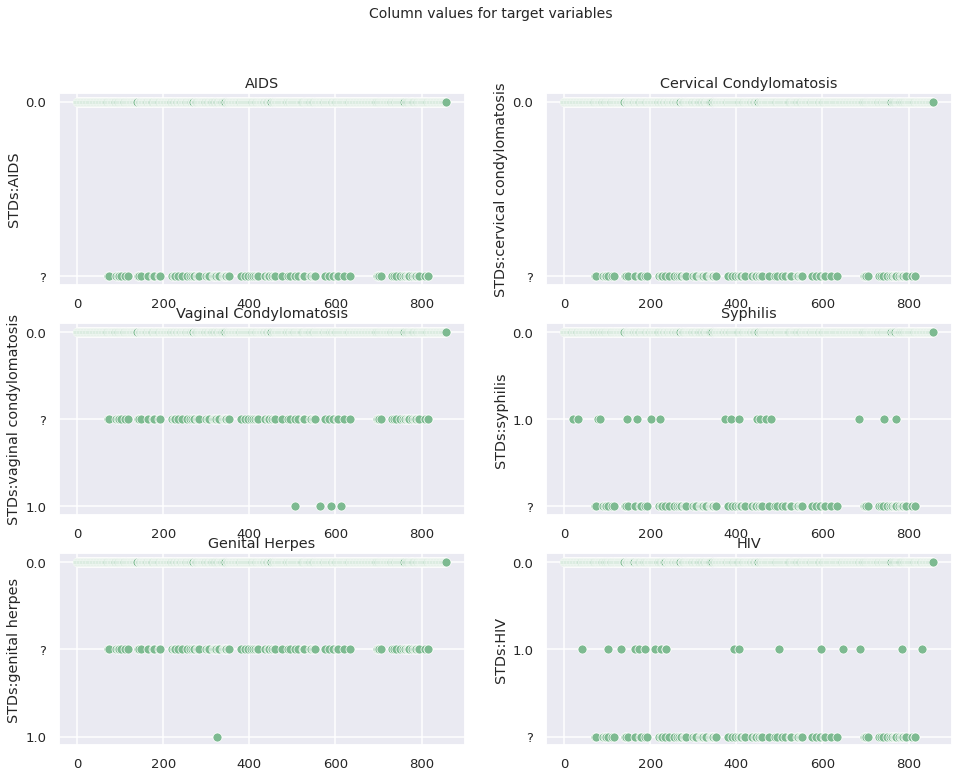

In [ ]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Column values for target variables", fontsize=14)

ax1 = fig.add_subplot(3,2, 1)
sns.scatterplot(data=df['STDs:AIDS'], ax=ax1)
t=ax1.set_title("AIDS")

ax2 = fig.add_subplot(3,2, 2)
sns.scatterplot(data=df['STDs:cervical condylomatosis'], ax=ax2)
t=ax2.set_title("Cervical Condylomatosis")

ax3 = fig.add_subplot(3,2, 3)
sns.scatterplot(data=df['STDs:vaginal condylomatosis'], ax=ax3)
t=ax3.set_title("Vaginal Condylomatosis")

ax4 = fig.add_subplot(3,2, 4)
sns.scatterplot(data=df['STDs:syphilis'], ax=ax4)
t=ax4.set_title("Syphilis")

ax5 = fig.add_subplot(3,2, 5)
sns.scatterplot(data=df['STDs:genital herpes'], ax=ax5)
t=ax5.set_title("Genital Herpes")

ax6 = fig.add_subplot(3,2, 6)
sns.scatterplot(data=df['STDs:HIV'], ax=ax6)
t=ax6.set_title("HIV")
plt.savefig("booleans_first.png")
plt.show()


Encode the missing values represented by ? with np.NaN and drop the columns which contain over 90% nan values (should be only 2 columns)

In [19]:
df1 = df.copy(deep=True)
df1 = encode_nans(df1)

# A 90% threshold removes 2 columns whereas 95% doesnt
null_threshold = 0.9
df1 = drop_nulls(df1, null_threshold)

df1.isnull().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

Start major pre-processing here.

Firstly, we convert the columns that should be integers, from strings to numerical (float64)

In [20]:
# Columns that should be converted to ints
# Note that columns without missing values are not included here
int_cols = ['Number of sexual partners','First sexual intercourse','Num of pregnancies',
            'Smokes (packs/year)','Smokes (years)','Hormonal Contraceptives (years)',
            'IUD (years)','STDs (number)']

mean_cols = ['Number of sexual partners','First sexual intercourse','Num of pregnancies',
            'Smokes (packs/year)','Smokes (years)','Hormonal Contraceptives (years)',
            'IUD (years)','STDs (number)','STDs: Time since first diagnosis',
            'STDs: Time since last diagnosis']

# Columns that contain nans
nan_cols = ['Smokes','Hormonal Contraceptives','IUD','STDs',
            'STDs:condylomatosis','STDs:cervical condylomatosis','STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis','STDs:syphilis','STDs:pelvic inflammatory disease',
            'STDs:genital herpes','STDs:molluscum contagiosum','STDs:AIDS','STDs:HIV',
            'STDs:Hepatitis B','STDs:HPV']

numeric_df = convert_col_to_numeric(df1, int_cols)
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    object 
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    object 
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    object 
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

Then, we will fill the missing values of the leftover columns (the boolean ones) with the mode of the column. Here arises the issue of the AIDS column where it only contains 0s and ?s. For this reason, the missing 105 values are filled with 0s as well.

In [21]:
df_mode = fill_nan_mode(numeric_df, nan_cols)
df_mode.isnull().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                  0
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives                 0
Hormonal Contraceptives (years)       108
IUD                                     0
IUD (years)                           117
STDs                                    0
STDs (number)                         105
STDs:condylomatosis                     0
STDs:cervical condylomatosis            0
STDs:vaginal condylomatosis             0
STDs:vulvo-perineal condylomatosis      0
STDs:syphilis                           0
STDs:pelvic inflammatory disease        0
STDs:genital herpes                     0
STDs:molluscum contagiosum              0
STDs:AIDS                               0
STDs:HIV                                0
STDs:Hepatitis B                  

Afterwards, we fill the integer column missing values with the mean of the column.

In [22]:
df_mean = fill_nan_mean(df_mode, mean_cols)
df_mean.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


Check that no values are missing, that all values are non-null and that the dtype is as intended (for now).

In [23]:
df_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    object 
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    object 
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    object 
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

Show the distribution of column values for the target variables. Here we see that there is major data imbalance. This will be fixed further down in the code.

Through literature review and the source of the data, we will be looking only at the Biopsy column and will be dropping all others.

Biopsy is the "gold standard" when it comes to cancer detection.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


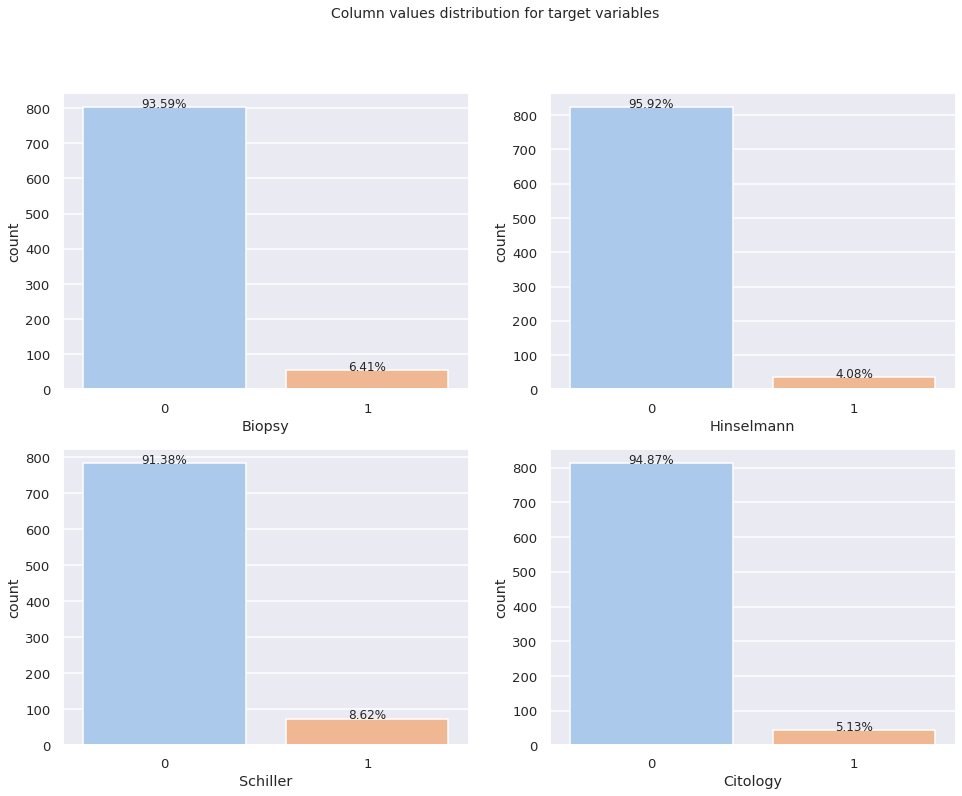

In [24]:
# Plot the target variable to confirm their type (boolean)

fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Column values distribution for target variables", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
p1 = sns.countplot(df_mean['Biopsy'], palette='pastel')
for p in p1.patches:
  height = p.get_height()
  p1.text(p.get_x()+p.get_width()/2.,
          height,
          f'{height/df.shape[0] * 100:.2f}%',
          ha='center', fontsize=12)

ax2 = fig.add_subplot(2,2, 2)
p2 = sns.countplot(df_mean['Hinselmann'], palette='pastel')
for p in p2.patches:
  height = p.get_height()
  p2.text(p.get_x()+p.get_width()/2.,
          height,
          f'{height/df.shape[0] * 100:.2f}%',
          ha='center', fontsize=12)

ax3 = fig.add_subplot(2,2, 3)
p3 = sns.countplot(df_mean['Schiller'], palette='pastel')
for p in p3.patches:
  height = p.get_height()
  p3.text(p.get_x()+p.get_width()/2.,
          height,
          f'{height/df.shape[0] * 100:.2f}%',
          ha='center', fontsize=12)

ax4 = fig.add_subplot(2,2, 4)
p4 = sns.countplot(df_mean['Citology'], palette='pastel')
for p in p4.patches:
  height = p.get_height()
  p4.text(p.get_x()+p.get_width()/2.,
          height,
          f'{height/df.shape[0] * 100:.2f}%',
          ha='center', fontsize=12)

plt.savefig("target_dist.png")


In [25]:
final_df = df_mean.copy(deep=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    object 
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    object 
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    object 
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

Drop the useless target columns and finalize conversion.

Convert all boolean columns to numeric ones and then to np.int64; This will encode all boolean values to either 0 or 1. It will also change the dtype to int64 instead of object (object raises issues with SHAP later on).

In [26]:
final_df.drop(['Hinselmann', 'Schiller', 'Citology'], axis=1, inplace=True)
final_df[int_cols] = final_df[int_cols].astype(np.int64)

bool_cols = final_df.select_dtypes(['object']).columns
for col in bool_cols:
  final_df[col] = pd.to_numeric(final_df[col]).astype(np.int64)

final_df.head()
# final_df.info()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Biopsy
0,18,4,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,1,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,52,5,16,4,1,37,37,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,46,3,21,4,0,0,0,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Age                                 858 non-null    int64
 1   Number of sexual partners           858 non-null    int64
 2   First sexual intercourse            858 non-null    int64
 3   Num of pregnancies                  858 non-null    int64
 4   Smokes                              858 non-null    int64
 5   Smokes (years)                      858 non-null    int64
 6   Smokes (packs/year)                 858 non-null    int64
 7   Hormonal Contraceptives             858 non-null    int64
 8   Hormonal Contraceptives (years)     858 non-null    int64
 9   IUD                                 858 non-null    int64
 10  IUD (years)                         858 non-null    int64
 11  STDs                                858 non-null    int64
 12  STDs (nu

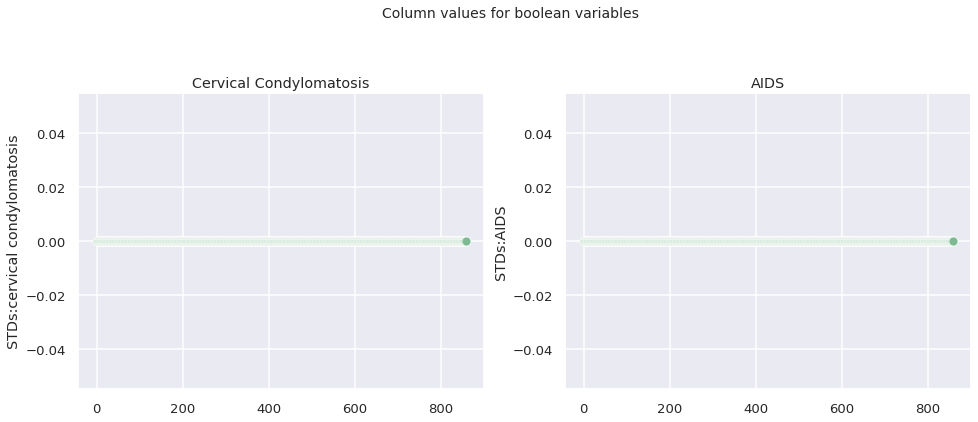

In [28]:
# These plots show that after dealing with missing values
# the columns for AIDS and Cervical Condylomatosis contain only values of 0 (False)
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Column values for boolean variables", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
sns.scatterplot(data=final_df['STDs:cervical condylomatosis'], ax=ax1)
t=ax1.set_title("Cervical Condylomatosis")

ax2 = fig.add_subplot(2,2, 2)
sns.scatterplot(data=final_df['STDs:AIDS'], ax=ax2)
t=ax2.set_title("AIDS")

plt.savefig("stds.png")

Show correlation matrix

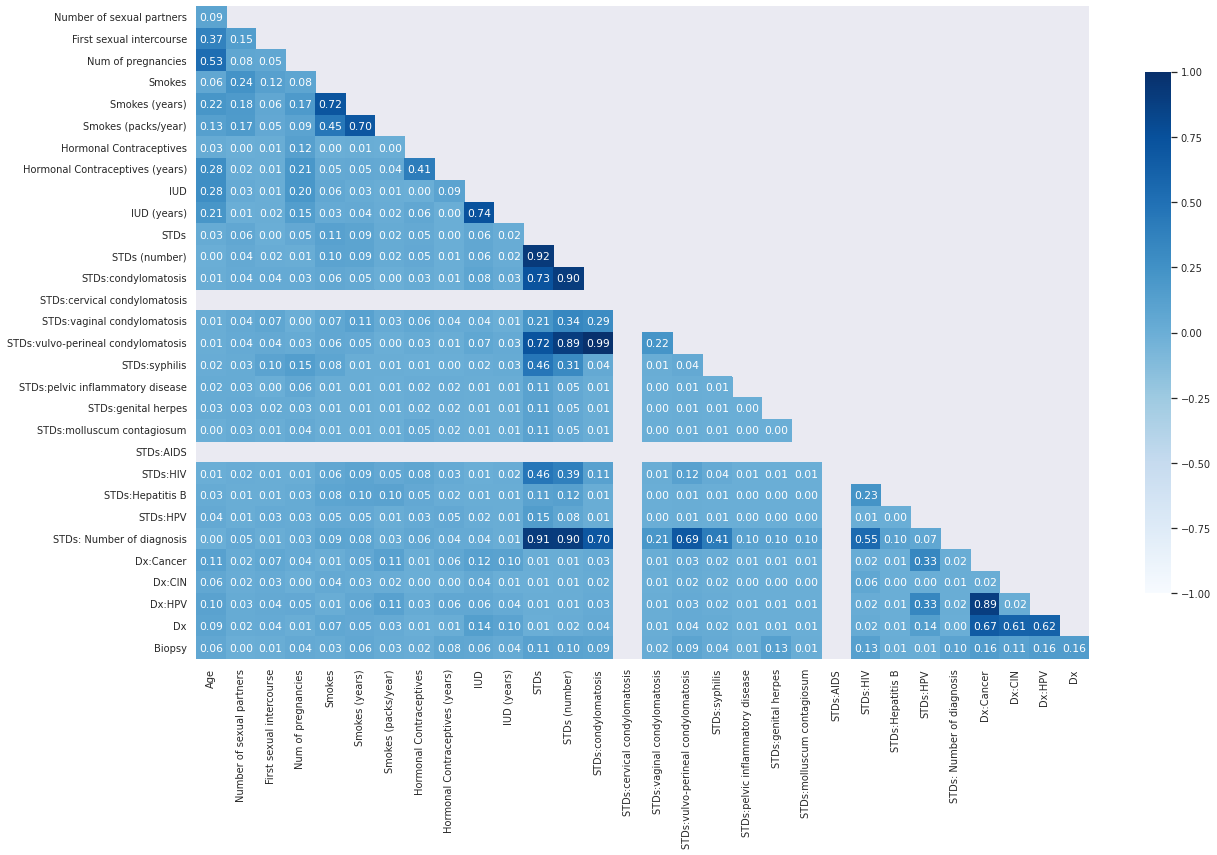

In [29]:
# get correlations
df_const_corr = final_df.corr().abs()
sns.set(font_scale=0.9)
fig, ax = plt.subplots(figsize=(20, 12))
# mask
mask = np.triu(np.ones_like(df_const_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_const_corr.iloc[1:,:-1].copy()
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)


plt.savefig("corr_matrix.png")
plt.show()

Due to the major data imbalance (seen previously in the code), we will be altering it now.


In [30]:
# Code from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
def perform_smote(df):
  import imblearn

  x1 = df.drop('Biopsy', axis=1)
  y1 = df.Biopsy

  sm = imblearn.over_sampling.SMOTE(random_state=42)

  x_sm, y_sm = sm.fit_resample(x1, y1)

  print(x1.shape)
  print(x_sm.shape)

  print('\n')
  print(y1.shape)
  print(y_sm.shape)

  return pd.concat([x_sm, y_sm], axis=1)

  # new_df = df.copy(deep=True)

Let's do some initial model training using SKlearn

### Without SMOTE

In [ ]:
final_df

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Biopsy
0,18,4,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,1,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,52,5,16,4,1,37,37,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,46,3,21,4,0,0,0,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
854,32,2,19,1,0,0,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
855,25,2,17,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
856,33,2,24,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
labels, input_ids = final_df['Biopsy'], final_df.drop('Biopsy', axis=1)

In [ ]:
labels

0      0
1      0
2      0
3      0
4      0
      ..
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 858, dtype: int64

In [ ]:
input_ids

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,18,4,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,1,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,52,5,16,4,1,37,37,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,46,3,21,4,0,0,0,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
854,32,2,19,1,0,0,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
855,25,2,17,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
856,33,2,24,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=1)

In [ ]:
print(f"Training input shape: {x_train.shape}")
print(f"Training label shape: {y_train.shape}")
print(f"Test input shape: {x_test.shape}")
print(f"Test label shape: {y_test.shape}")

Training input shape: (686, 30)
Training label shape: (686,)
Test input shape: (172, 30)
Test label shape: (172,)


In [ ]:
model = RandomForestClassifier(verbose=0, random_state=2)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=2)

In [ ]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [ ]:


print(f"RandomForest Classifier has accuracy of {round(accuracy_score(y_pred_test, y_test.values), 3)* 100}%")

RandomForest Classifier has accuracy of 92.4%


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

In [ ]:
print(f"The SHAP values have the following shape -> {np.array(shap_values).shape}")

The SHAP values have the following shape -> (2, 686, 30)


In [ ]:
sv = np.array(shap_values)
y = model.predict(x_train)

In [ ]:
shap_values_ = sv.transpose((1,0,2))

check = np.allclose(
    model.predict_proba(x_train),
    shap_values_.sum(2) + explainer.expected_value
)

if check:
  print("The predictions from the model are same as the ones by SHAP")
else:
  print("The predictions from the model are NOT the same as the ones by SHAP.")

The predictions from the model are same as the ones by SHAP


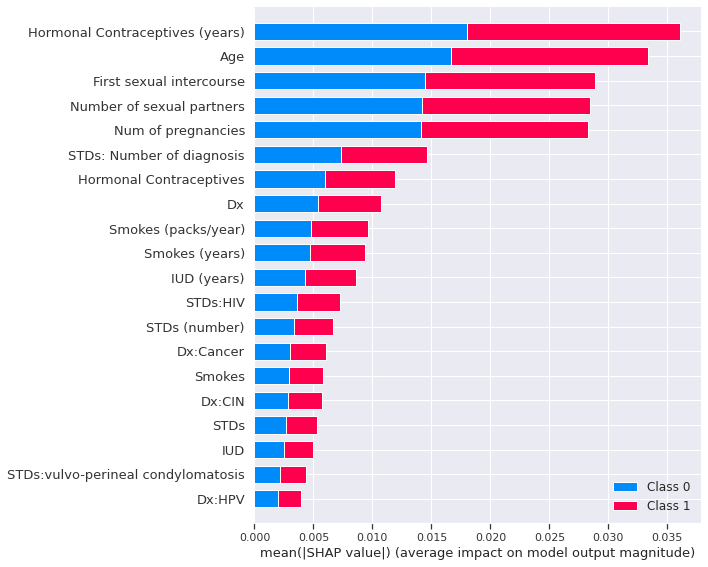

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

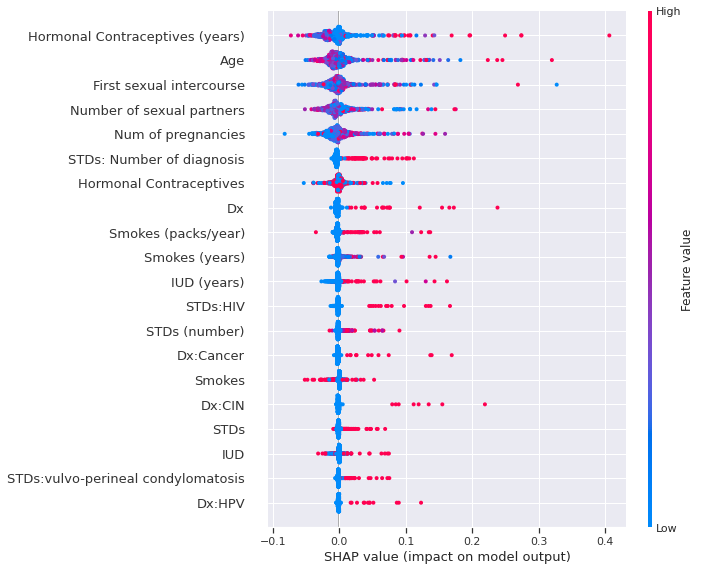

In [ ]:
# Show the shap values for class 1 - HAS biopsy
shap.summary_plot(shap_values[1], x_train)

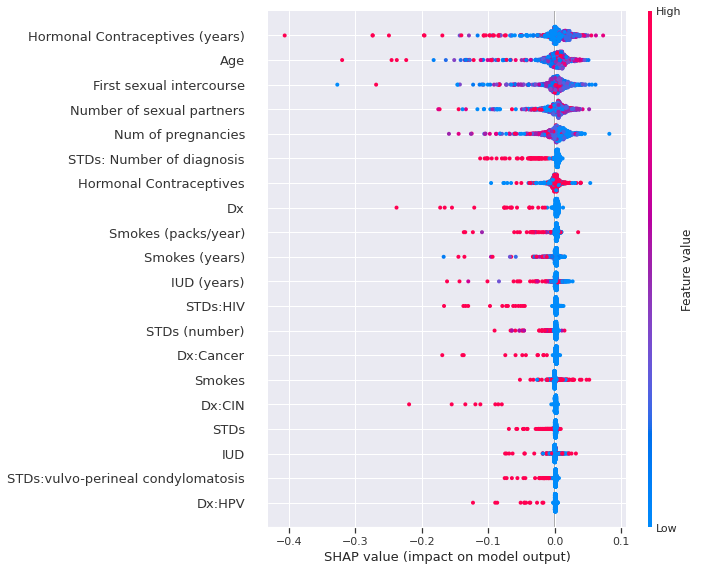

In [ ]:
# Show the shap values for class 0 - HAS NOT biopsy
shap.summary_plot(shap_values[0], x_train)

Here I am showing the coefficient values from the SKlearn library. This is another way to visualize the importance of each feature

In [ ]:
feature_names = list(input_ids.columns)

coefs = pd.DataFrame(model.feature_importances_, columns=['Coefficients'],index=feature_names)

coefs

,Coefficients
Age,0.199573
Number of sexual partners,0.108333
First sexual intercourse,0.155805
Num of pregnancies,0.097308
Smokes,0.014571
Smokes (years),0.041617
Smokes (packs/year),0.024389
Hormonal Contraceptives,0.028567
Hormonal Contraceptives (years),0.139363
IUD,0.019430


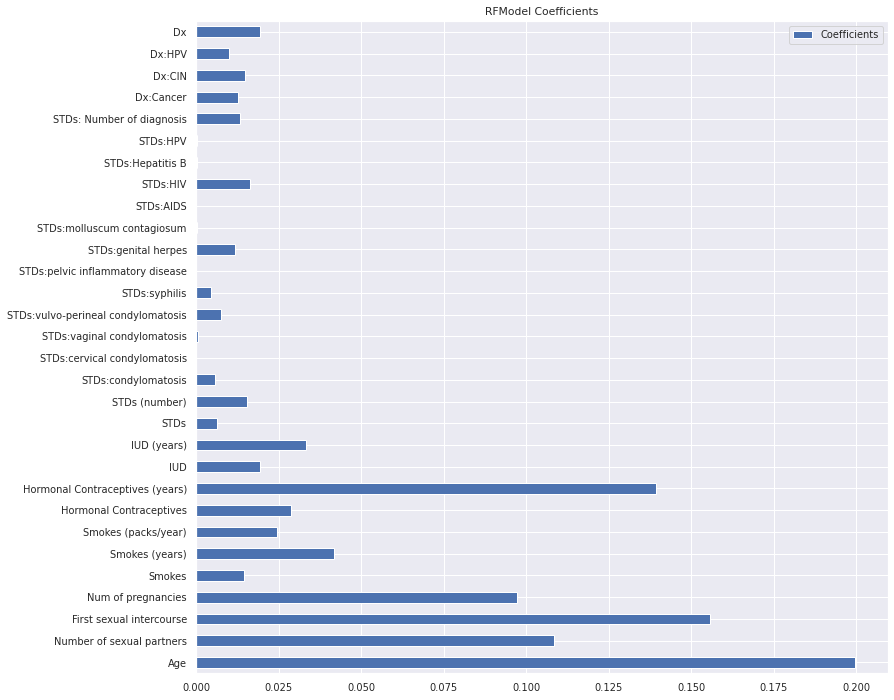

In [ ]:
coefs.plot(kind="barh", figsize=(16,12))
plt.title("RFModel Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

### With SMOTE

In [31]:
final_df

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Biopsy
0,18,4,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,1,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,52,5,16,4,1,37,37,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,46,3,21,4,0,0,0,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
854,32,2,19,1,0,0,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
855,25,2,17,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
856,33,2,24,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
final_df_smote = perform_smote(final_df)

(858, 30)
(1606, 30)


(858,)
(1606,)


In [33]:
labels, input_ids = final_df_smote['Biopsy'], final_df_smote.drop('Biopsy', axis=1)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=1)
print(f"Training input shape: {x_train.shape}")
print(f"Training label shape: {y_train.shape}")
print(f"Test input shape: {x_test.shape}")
print(f"Test label shape: {y_test.shape}")

Training input shape: (1284, 30)
Training label shape: (1284,)
Test input shape: (322, 30)
Test label shape: (322,)


In [35]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

print(f"RandomForest Classifier has accuracy of {round(accuracy_score(y_pred_test, y_test.values), 3)* 100}%")

RandomForest Classifier has accuracy of 88.2%


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

print(f"The SHAP values have the following shape -> {np.array(shap_values).shape}")

sv = np.array(shap_values)
y = model.predict(x_train)

shap_values_ = sv.transpose((1,0,2))

check = np.allclose(
    model.predict_proba(x_train),
    shap_values_.sum(2) + explainer.expected_value
)

if check:
  print("The predictions from the model are same as the ones by SHAP")
else:
  print("The predictions from the model are NOT the same as the ones by SHAP.")

The SHAP values have the following shape -> (2, 1284, 30)
The predictions from the model are same as the ones by SHAP


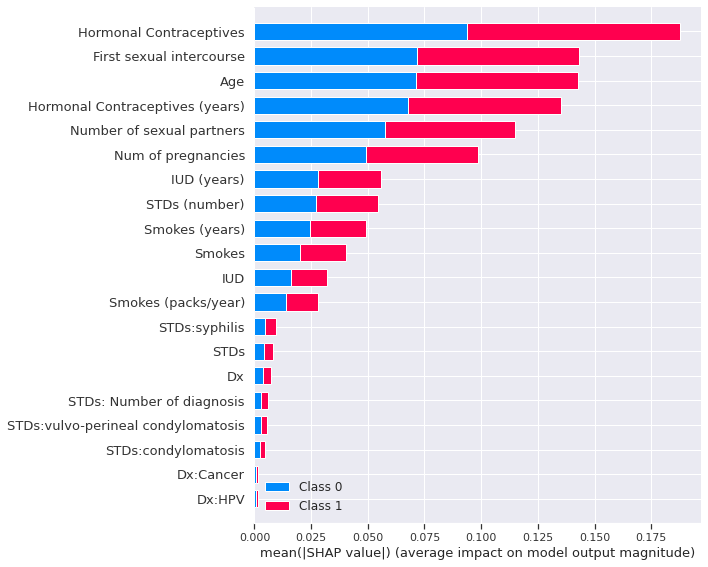

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

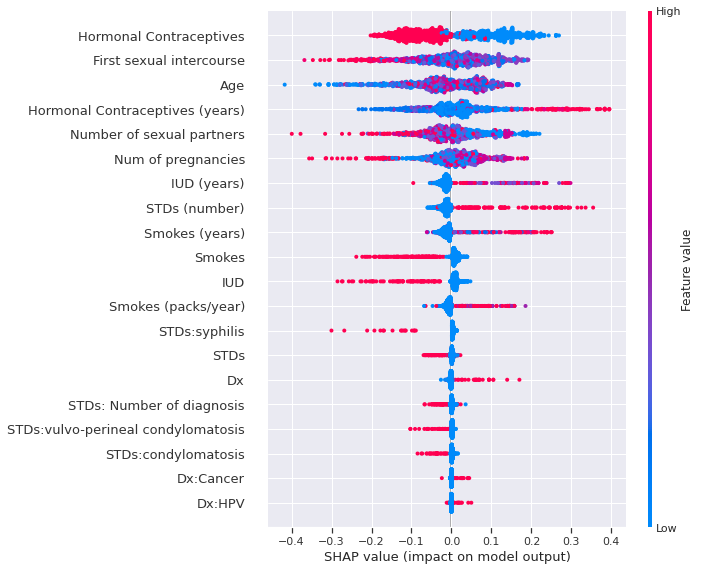

In [ ]:
# Show the shap values for class 1 - HAS biopsy
shap.summary_plot(shap_values[1], x_train)

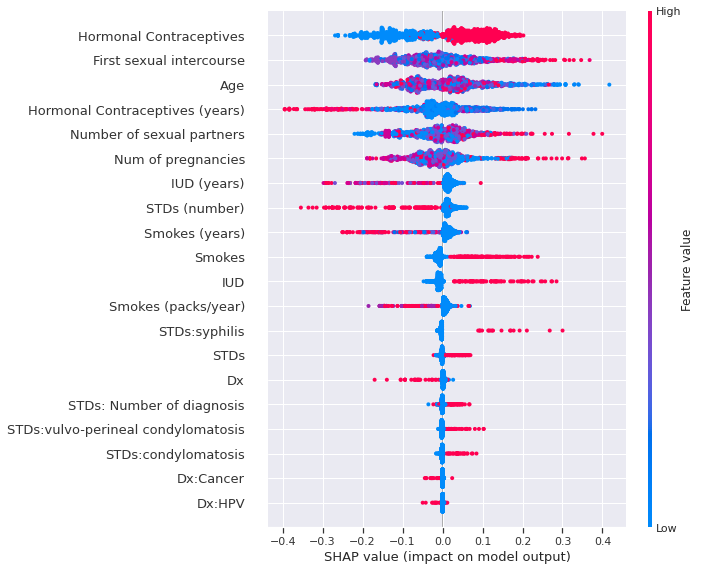

In [ ]:
# Show the shap values for class 1 - HAS biopsy
shap.summary_plot(shap_values[0], x_train)

In [ ]:
feature_names = list(input_ids.columns)

coefs = pd.DataFrame(model.feature_importances_, columns=['Coefficients'],index=feature_names)

coefs

,Coefficients
Age,0.255884
Number of sexual partners,0.104578
First sexual intercourse,0.166321
Num of pregnancies,0.098216
Smokes,0.017712
Smokes (years),0.042192
Smokes (packs/year),0.020137
Hormonal Contraceptives,0.057508
Hormonal Contraceptives (years),0.119647
IUD,0.016449


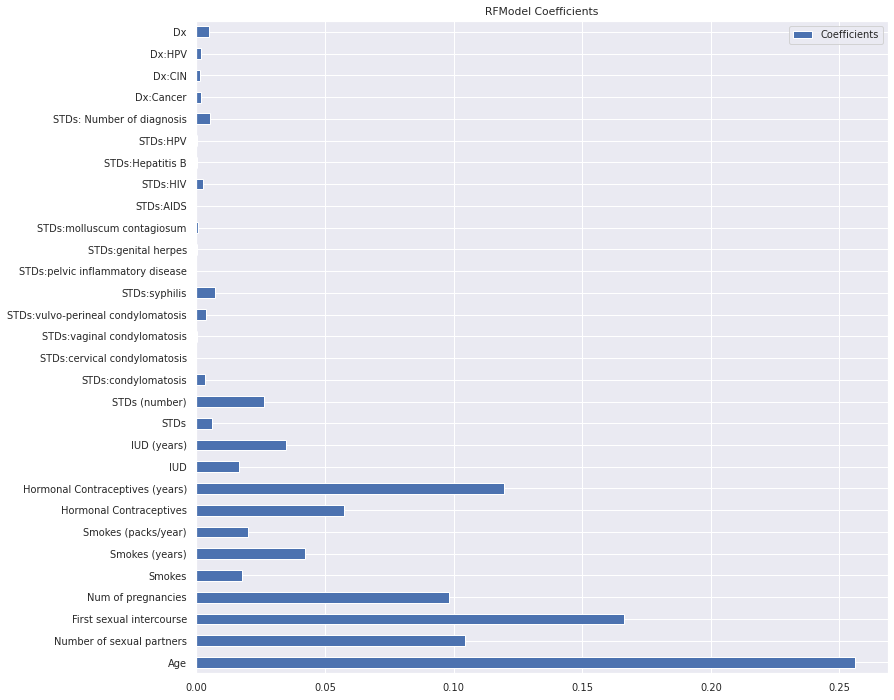

In [ ]:
coefs.plot(kind="barh", figsize=(16,12))
plt.title("RFModel Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

---

### Next stuff

In [39]:


classifiers = {
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
  training_score = cross_val_score(classifier, x_train, y_train, cv=5)
  classifier.fit(x_train, y_train)
  y_preds = classifier.predict(x_test)
  test_score = accuracy_score(y_test, y_preds)
  print(f"Classifier: {classifier.__class__.__name__} has a Train score of {round(training_score.mean(), 3) * 100}% accuracy and Test score of {round(test_score, 3) * 100}% accuracy")

Classifier: RandomForestClassifier has a Train score of 90.5% accuracy and Test score of 89.1% accuracy
Classifier: DecisionTreeClassifier has a Train score of 84.7% accuracy and Test score of 86.0% accuracy


In [ ]:
model = RandomForestClassifier()
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
params = {
    'n_estimators': [50, 100, 150, 200, 250],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}

clf = GridSearchCV(model, params, verbose=3)
clf.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END criterion=gini, max_features=auto, n_estimators=50;, score=0.891 total time=   0.1s
[CV 2/5] END criterion=gini, max_features=auto, n_estimators=50;, score=0.911 total time=   0.1s
[CV 3/5] END criterion=gini, max_features=auto, n_estimators=50;, score=0.918 total time=   0.1s
[CV 4/5] END criterion=gini, max_features=auto, n_estimators=50;, score=0.875 total time=   0.1s
[CV 5/5] END criterion=gini, max_features=auto, n_estimators=50;, score=0.898 total time=   0.1s
[CV 1/5] END criterion=gini, max_features=auto, n_estimators=100;, score=0.918 total time=   0.2s
[CV 2/5] END criterion=gini, max_features=auto, n_estimators=100;, score=0.914 total time=   0.2s
[CV 3/5] END criterion=gini, max_features=auto, n_estimators=100;, score=0.918 total time=   0.2s
[CV 4/5] END criterion=gini, max_features=auto, n_estimators=100;, score=0.864 total time=   0.2s
[CV 5/5] END criterion=gini, max_features=auto, n_estimators=

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200, 250]},
             verbose=3)

In [ ]:
clf.best_params_

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}

In [40]:
classifier = RandomForestClassifier(criterion='gini',  max_features='sqrt', n_estimators=100)
training_score = cross_val_score(classifier, x_train, y_train, cv=5)
classifier.fit(x_train, y_train)
y_preds = classifier.predict(x_test)
test_score = accuracy_score(y_test, y_preds)

print(f"Classifier: {classifier.__class__.__name__} has a Train score of {round(training_score.mean(), 3) * 100}% accuracy and Test score of {round(test_score, 3) * 100}% accuracy")

Classifier: RandomForestClassifier has a Train score of 91.0% accuracy and Test score of 87.9% accuracy
